# Import libraries

In [1]:
# uncomment to install libraries
# ! pip install numpy pandas matplotlib seaborn nltk sklearn regex geopy patsy mplot3d-dragger gmaps
# ! python -m spacy download en_core_web_sm
# nltk.download("stopwords")
# jupyter nbextension enable --py gmaps

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import patsy
import re
import geopy
from geopy import distance
import gmaps

# English stop words
english_stop_words = nltk.corpus.stopwords.words("english")

# word net
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nicholasmichalak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Seaborn look

In [2]:
sns.set(context = "notebook", style = "darkgrid", palette = "colorblind", font = "sans-serif")

# Define functions

## Text processing
* Special characters
* Lower case
* White space
* Tokenize with WordPunctTokenizer
* Remove English stop words
Source: [Traditional Methods for Text Data by Dipanjan (DJ) Sarkar
](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41)

In [3]:
# process a single document's text
def process_document(document):
    try:
        # lower case
        document_processed = document.lower()
    
        # remove white space
        document_processed = document_processed.strip()
    
        # tokenize document
        tokens = nltk.WordPunctTokenizer().tokenize(document_processed)
    
        # filter stopwords out of document and lemmatize
        tokens_processed = [WordNetLemmatizer().lemmatize(token) for token in tokens if token not in english_stop_words and len(token) > 2]
        
        # remove special characters
        tokens_processed = [token for token in tokens_processed if token.isalpha()]
    
        # re-create document from filtered tokens and return
        return " ".join(tokens_processed)
    except:
        return None

# vectorize process_document for processing entire corpus of documents
process_corpus = np.vectorize(process_document)

## Other

In [4]:
# Geocoder using the Google Maps v3 API
api_key = open("next_escape/google_maps_api_key.txt").readlines()[0]
googlev3_locator = geopy.geocoders.GoogleV3(api_key = api_key)

# address, latitude, and longitude
def get_lat_long(address):
    # look up location
    location = googlev3_locator.geocode(address)
    return location.address, location.latitude, location.longitude

# recode difficulty_level
def recode_difficulty(x):
    if x == "Very easy":
        return 0
    elif x == "Easy":
        return 1
    elif x == "Average":
        return 2
    elif x == "Difficult":
        return 3
    elif x == "Very difficult":
        return 4
    else:
        return "None"

# recode fear_level
def recode_fear(x):
    if x == "Not scary":
        return 0
    elif x == "A little scary":
        return 1
    elif x == "Scary":
        return 2
    elif x == "Very scary":
        return 3
    else:
        return "None"

# minumum age
def code_minimum_age(x):
    if "+" in str(x):
        return str(x).strip("+")
    else:
        return str(x).split(" - ")[0]

# Read data
* State and city data
* Room data (e.g., address, fear level, success rate)
* Reviews
* Tags

## State and city data

In [5]:
state_city_room_url = pd.read_csv("next_escape/data/state_city_room_url_df.csv")

# See it
state_city_room_url

,state,city,company_and_room,woe_room_url
0,Alabama,Auburn,Auburn Escape Zones: The Cabin,https://worldofescapes.com/auburn/quests/aubur...
1,Alabama,Auburn,Auburn Escape Zones: Imprisoned,https://worldofescapes.com/auburn/quests/aubur...
2,Alabama,Auburn,Auburn Escape Zones: Vault,https://worldofescapes.com/auburn/quests/aubur...
3,Alabama,Auburn,Auburn Escape Zones: The Puzzler vs Superheroes,https://worldofescapes.com/auburn/quests/aubur...
4,Alabama,Auburn,Auburn Escape Zones: Black Beard's Brig,https://worldofescapes.com/auburn/quests/aubur...
...,...,...,...,...
8001,"Washington, D.C.","Washington, D.C.",Escape Quest: The King’s Ransom,https://worldofescapes.com/washington/quests/e...
8002,"Washington, D.C.","Washington, D.C.",PanIQ Escape Room: Primal Quest,https://worldofescapes.com/washington/quests/p...
8003,"Washington, D.C.","Washington, D.C.",Escape Room Live: Ghostbusters!,https://worldofescapes.com/washington/quests/e...
8004,"Washington, D.C.","Washington, D.C.",Escape Room Live: Friday the 13th,https://worldofescapes.com/washington/quests/e...


## Room data

In [6]:
room_data = pd.read_csv("next_escape/data/room_data.csv")

# recode difficulty_level
def recode_difficulty(x):
    if x == "Very easy":
        return 0
    elif x == "Easy":
        return 1
    elif x == "Average":
        return 2
    elif x == "Difficult":
        return 3
    elif x == "Very difficult":
        return 4
    else:
        return "None"
room_data["difficulty_int"] = room_data["difficulty_level"].apply(lambda x: recode_difficulty(x))

# convert "None" to None
room_data = room_data.mask(room_data.eq("None"))

# See it
room_data

/Users/nicholasmichalak/opt/anaconda3/envs/escape_room_reviews/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,room_title,woe_room_url,room_address,room_description,player_range,time_limit,difficulty_level,fear_level,age_requirement,success_rate,min_players,max_players,time_limit_str,minimum_age,difficulty_int,fear_int,query_address,room_latitude,room_longitude
0,"Escape room ""The Pirate's Curse"" by Escape Roo...",https://worldofescapes.com/washington/quests/e...,"3345 M Street NW, Washington, DC 20007","Ahoy, Matey! All aboard Ye Pirate Ship! All wh...",8-10,60.0,Very difficult,Not scary,5+,NaN,8.0,10.0,60 minutes,5.0,4,0.0,"3345 M St NW, Washington, DC 20007, USA",38.905259,-77.067487
1,"Escape room ""The Time Machine"" by MindTrix in ...",https://worldofescapes.com/portland/quests/mid...,"12000 SE 82nd Ave #1009 Happy Valley, OR 97086",Scientists are on the verge of discovering tim...,2-8,60.0,Difficult,Not scary,14+,NaN,2.0,8.0,60 minutes,14.0,3,0.0,"12000 SE 82nd Ave, Happy Valley, OR 97086, USA",45.435929,-122.575935
2,"Escape room ""National Treasure"" by The Escape ...",https://worldofescapes.com/new-brunswick/quest...,"45 Lafayette Rd Fords, NJ 08863",While on vacation with a group of your buddies...,2-10,60.0,Very difficult,Not scary,NaN,NaN,2.0,10.0,60 minutes,NaN,4,0.0,"45 Lafayette Rd, Fords, NJ 08863, USA",40.547972,-74.322685
3,"Escape room ""The Lost Antidote"" by The Escape ...",https://worldofescapes.com/little-rock/quests/...,"1214 S Main St Little Rock, AR 72202","Dr. Stapleton, an evil scientist, has poisoned...",2-7,60.0,Average,Not scary,13+,0.40,2.0,7.0,60 minutes,13.0,2,0.0,"1214 S Main St, Little Rock, AR 72202, USA",34.736756,-92.272776
4,"Escape room ""Outbreak: Find the Cure"" by Maste...",https://worldofescapes.com/overland-park/quest...,"7810 West 151st Street Overland Park, KS 66223",The CDC is on lockdown after a deadly virus wa...,2-10,60.0,Difficult,Not scary,NaN,0.21,2.0,10.0,60 minutes,NaN,3,0.0,"7810 151st St, Overland Park, KS 66223, USA",38.855056,-94.676241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7447,"Escape room ""Nuclear Shuttle"" by Escape Rooms ...",https://worldofescapes.com/dallas/quests/escap...,"1565 W Main ST #495 Lewisville, TX 75077",Your team is the second shift crew for the Orb...,2-8,60.0,Difficult,Not scary,13+,0.30,2.0,8.0,60 minutes,13.0,3,0.0,"1565 W Main St #495, Lewisville, TX 75067, USA",33.043593,-97.034234
7448,"Escape room ""The Wizard's Chamber"" by Escape N...",https://worldofescapes.com/warren-oh/quests/es...,"200 Chestnut Avenue Northeast Suite C Warren, ...",The founders created a vessel to tether their ...,4-8,60.0,Difficult,Not scary,10+,NaN,4.0,8.0,60 minutes,10.0,3,0.0,"200 Chestnut Ave NE Suite C, Warren, OH 44483,...",41.237727,-80.808754
7449,"Escape room ""Houdini's Magic Cell - Destinatio...",https://worldofescapes.com/andover/quests/all-...,"301 Mt Hope Ave Rockaway, NJ 07866","Just like Houdini began, you will start your q...",2-10,60.0,Difficult,Not scary,14+,NaN,2.0,10.0,60 minutes,14.0,3,0.0,"301 Mt Hope Ave, Rockaway, NJ 07866, USA",40.907075,-74.553423
7450,"Escape room ""High Noon in the Old West"" by Tim...",https://worldofescapes.com/atlanta/quests/time...,"1441 Dresden Dr Suite 230 Atlanta, GA 30319",It is 1899 and the final push to tame the wild...,1-10,60.0,Average,Not scary,12+,NaN,1.0,10.0,60 minutes,12.0,2,0.0,"1441 Dresden Dr #230, Atlanta, GA 30319, USA",33.860687,-84.330182


### Join with state and city data

In [7]:
state_city_room_data = state_city_room_url.merge(room_data, left_on = "woe_room_url", right_on = "woe_room_url", how = "right")

# see it
state_city_room_data

,state,city,company_and_room,woe_room_url,room_title,room_address,room_description,player_range,time_limit,difficulty_level,...,success_rate,min_players,max_players,time_limit_str,minimum_age,difficulty_int,fear_int,query_address,room_latitude,room_longitude
0,Alabama,Auburn,Auburn Escape Zones: The Cabin,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""The Cabin"" by Auburn Escape Zones...","1234 Commerce Dr Auburn, AL 36830",You were returning from a trip to your uncle's...,2-8,60.0,Difficult,...,0.54,2.0,8.0,60 minutes,10.0,3,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
1,Alabama,Auburn,Auburn Escape Zones: Imprisoned,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Imprisoned"" by Auburn Escape Zone...","1234 Commerce Dr Auburn, AL 36830",Your friend is being framed for a crime he did...,2-8,60.0,Average,...,0.62,2.0,8.0,60 minutes,10.0,2,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
2,Alabama,Auburn,Auburn Escape Zones: Vault,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Vault"" by Auburn Escape Zones in ...","1234 Commerce Dr Auburn, AL 36830",It’s Grand Opening day at the new branch and p...,4-8,60.0,Average,...,NaN,4.0,8.0,60 minutes,10.0,2,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
3,Alabama,Auburn,Auburn Escape Zones: The Puzzler vs Superheroes,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""The Puzzler vs Superheroes"" by Au...","1234 Commerce Dr Auburn, AL 36830",The Puzzler is up to his old tricks again! He ...,2-10,60.0,Difficult,...,0.55,2.0,10.0,60 minutes,10.0,3,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
4,Alabama,Auburn,Auburn Escape Zones: Black Beard's Brig,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Black Beard's Brig"" by Auburn Esc...","1234 Commerce Dr Auburn, AL 36830",Ahoy Matey! Your crew has been captured by Bla...,2-8,60.0,Average,...,0.53,2.0,8.0,60 minutes,10.0,2,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7927,"Washington, D.C.","Washington, D.C.",Escape Room Live: Ghostbusters!,https://worldofescapes.com/washington/quests/e...,"Escape room ""Ghostbusters!"" by Escape Room Liv...","3345 M Street NW, Washington, DC 20007","WHO YOU GONNA CALL? Help Venkman, Spengler, St...",2-10,45.0,Difficult,...,NaN,2.0,10.0,45 minutes,5.0,3,0.0,"3345 M St NW, Washington, DC 20007, USA",38.905259,-77.067487
7928,"Washington, D.C.","Washington, D.C.",Escape Room Live: Friday the 13th,https://worldofescapes.com/washington/quests/e...,"Escape room ""Friday the 13th"" by Escape Room L...","3345 M Street NW, Washington, DC 20007",Ch Ch Ch Ah Ah Ah! Jason is back and he just w...,2-10,45.0,Difficult,...,NaN,2.0,10.0,45 minutes,5.0,3,0.0,"3345 M St NW, Washington, DC 20007, USA",38.905259,-77.067487
7929,"Washington, D.C.","Washington, D.C.",Escape Room Live: Runaway Subway,https://worldofescapes.com/washington/quests/e...,"Escape room ""Runaway Subway"" by Escape Room Li...","3345 M Street NW, Washington, DC 20007","Agents, your former ally, Agent X, has remotel...",2-10,45.0,Average,...,NaN,2.0,10.0,45 minutes,5.0,2,0.0,"3345 M St NW, Washington, DC 20007, USA",38.905259,-77.067487
7930,NaN,NaN,NaN,https://worldofescapes.com/orange-county/quest...,"Escape room ""Central Bank"" by Fox in a Box Ora...","123 W. Amerige Ave., Fullerton CA 92832",You are a group of well-informed thieves. It h...,2-6,60.0,Difficult,...,0.23,2.0,6.0,60 minutes,4.0,3,0.0,"123 W Amerige Ave, Fullerton, CA 92832, USA",33.872032,-117.925247


### Some rows are missing state, city, and room data

In [8]:
state_city_room_data.loc[state_city_room_data["company_and_room"].isnull(), :]

,state,city,company_and_room,woe_room_url,room_title,room_address,room_description,player_range,time_limit,difficulty_level,...,success_rate,min_players,max_players,time_limit_str,minimum_age,difficulty_int,fear_int,query_address,room_latitude,room_longitude
7930,NaN,NaN,NaN,https://worldofescapes.com/orange-county/quest...,"Escape room ""Central Bank"" by Fox in a Box Ora...","123 W. Amerige Ave., Fullerton CA 92832",You are a group of well-informed thieves. It h...,2-6,60.0,Difficult,...,0.23,2.0,6.0,60 minutes,4.0,3,0.0,"123 W Amerige Ave, Fullerton, CA 92832, USA",33.872032,-117.925247
7931,NaN,NaN,NaN,https://worldofescapes.com/orange-county/quest...,"Escape room ""303 Coulrophobia Ln."" by Escape t...","26469 Rancho Pkwy S Lake Forest, CA 92630",Pets have been mysteriously disappearing in yo...,4-10,60.0,Average,...,NaN,4.0,10.0,60 minutes,NaN,2,2.0,"26469 Rancho Pkwy S, Lake Forest, CA 92630, USA",33.675809,-117.672521


#### Fill those in

In [9]:
# add state
state_city_room_data.loc[[7930, 7931], "state"] = "California"

# add state city
state_city_room_data.loc[[7930, 7931], "city"] = ["Fullerton", "Forest"]

# add compnay and room
state_city_room_data.loc[[7930, 7931], "company_and_room"] = ["Fox in a Box Orange County: Central Bank", "Escape the Place: 303 Coulrophobia Ln."]

# reindex
state_city_room_data = state_city_room_data.sort_values(by = ["state", "city"]).reset_index()

# see it
state_city_room_data

,index,state,city,company_and_room,woe_room_url,room_title,room_address,room_description,player_range,time_limit,...,success_rate,min_players,max_players,time_limit_str,minimum_age,difficulty_int,fear_int,query_address,room_latitude,room_longitude
0,0,Alabama,Auburn,Auburn Escape Zones: The Cabin,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""The Cabin"" by Auburn Escape Zones...","1234 Commerce Dr Auburn, AL 36830",You were returning from a trip to your uncle's...,2-8,60.0,...,0.54,2.0,8.0,60 minutes,10.0,3,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
1,1,Alabama,Auburn,Auburn Escape Zones: Imprisoned,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Imprisoned"" by Auburn Escape Zone...","1234 Commerce Dr Auburn, AL 36830",Your friend is being framed for a crime he did...,2-8,60.0,...,0.62,2.0,8.0,60 minutes,10.0,2,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
2,2,Alabama,Auburn,Auburn Escape Zones: Vault,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Vault"" by Auburn Escape Zones in ...","1234 Commerce Dr Auburn, AL 36830",It’s Grand Opening day at the new branch and p...,4-8,60.0,...,NaN,4.0,8.0,60 minutes,10.0,2,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
3,3,Alabama,Auburn,Auburn Escape Zones: The Puzzler vs Superheroes,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""The Puzzler vs Superheroes"" by Au...","1234 Commerce Dr Auburn, AL 36830",The Puzzler is up to his old tricks again! He ...,2-10,60.0,...,0.55,2.0,10.0,60 minutes,10.0,3,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
4,4,Alabama,Auburn,Auburn Escape Zones: Black Beard's Brig,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Black Beard's Brig"" by Auburn Esc...","1234 Commerce Dr Auburn, AL 36830",Ahoy Matey! Your crew has been captured by Bla...,2-8,60.0,...,0.53,2.0,8.0,60 minutes,10.0,2,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7927,7851,Wyoming,Gillette,307 Mysteries: Wacked Science,https://worldofescapes.com/gillette/quests/307...,"Escape room ""Wacked Science"" by 307 Mysteries ...","2800 N US Hwy 14-16, Gillette, WY 82716",A mad scientist has kidnapped you and your fri...,2-7,60.0,...,NaN,2.0,7.0,60 minutes,NaN,2,0.0,"2800 N US Hwy 14-16, Gillette, WY 82716, USA",44.322399,-105.528686
7928,7852,Wyoming,Gillette,307 Mysteries: Lifting The Jewels,https://worldofescapes.com/gillette/quests/307...,"Escape room ""Lifting The Jewels"" by 307 Myster...","2800 N US Hwy 14-16, Gillette, WY 82716",The local Museum’s rare jewel collection was s...,2-4,60.0,...,NaN,2.0,4.0,60 minutes,NaN,2,0.0,"2800 N US Hwy 14-16, Gillette, WY 82716, USA",44.322399,-105.528686
7929,7853,Wyoming,Gillette,307 Mysteries: Miss Molly's Zombie Reboot,https://worldofescapes.com/gillette/quests/307...,"Escape room ""Miss Molly's Zombie Reboot"" by 30...","2800 N US Hwy 14-16, Gillette, WY 82716",Zombies have escaped from containment faciliti...,2-5,60.0,...,NaN,2.0,5.0,60 minutes,NaN,2,0.0,"2800 N US Hwy 14-16, Gillette, WY 82716, USA",44.322399,-105.528686
7930,7854,Wyoming,Sheridan,Escapade: Mystic Mistake,https://worldofescapes.com/sheridan/quests/esc...,"Escape room ""Mystic Mistake"" by Escapade in Sh...","237 N. Main St., Suite 50, Sheridan, WY 82801",Madam Zara has made a grave error in her quest...,3-5,60.0,...,NaN,3.0,5.0,60 minutes,NaN,2,0.0,"237 N Main St #50, Sheridan, WY 82801, USA",44.800304,-106.955458


### Add state, city, and company, and room data

In [10]:
state_city_room_data["city_state_company_room"] = [str(city) + ", " + str(state) + " - " + str(room) for city, state, room in zip(state_city_room_data["city"], state_city_room_data["state"], state_city_room_data["company_and_room"])]

## Room reviews data

In [11]:
review_data = pd.read_csv("next_escape/data/review_data.csv")

# See it
review_data

,room_title,woe_room_url,review_id,review
0,"Escape room ""Murder of Crows"" by Keynundrum in...",https://worldofescapes.com/topeka/quests/keynu...,0,Love the room design of Murder of Crows! Nice ...
1,"Escape room ""Murder of Crows"" by Keynundrum in...",https://worldofescapes.com/topeka/quests/keynu...,1,First time anyone in our group had done an esc...
2,"Escape room ""Murder of Crows"" by Keynundrum in...",https://worldofescapes.com/topeka/quests/keynu...,2,So much fun!!! Came so close to finishing the ...
3,"Escape room ""Immersive X"" by XscapeQuest in Sa...",https://worldofescapes.com/bay-city/quests/xsc...,0,NaN
4,"Escape room ""Captain's Maxwell's Shipwrecked"" ...",https://worldofescapes.com/milwaukee/quests/te...,0,"We were a group of 5 couples, with one couple ..."
...,...,...,...,...
19830,"Escape room ""Fatal Attraction"" by Cracked Norm...",https://worldofescapes.com/oklahoma-city/quest...,0,We did the Fatal Attraction room which was a c...
19831,"Escape room ""Fatal Attraction"" by Cracked Norm...",https://worldofescapes.com/oklahoma-city/quest...,1,I took five 12-13 year old girls to do Fatal A...
19832,"Escape room ""Fatal Attraction"" by Cracked Norm...",https://worldofescapes.com/oklahoma-city/quest...,2,We took my dad for Father's Day to Fatal Attra...
19833,"Escape room ""Chasm"" by Beat the Room in Sacram...",https://worldofescapes.com/sacramento/quests/b...,0,We had 6 family members working together and h...


## Room tags data

In [12]:
tag_data = pd.read_csv("next_escape/data/tag_data.csv")

# See it
tag_data

,room_title,woe_room_url,tag_id,tag
0,"Escape room ""The Rec Room"" by Escape the Room ...",https://worldofescapes.com/detroit/quests/esca...,0,Public Ticketing
1,"Escape room ""The Rec Room"" by Escape the Room ...",https://worldofescapes.com/detroit/quests/esca...,1,Up to eight players
2,"Escape room ""The Play House"" by Escape Space G...",https://worldofescapes.com/portland/quests/esc...,0,Up to eight players
3,"Escape room ""The Chocolate Factory"" by Escape ...",https://worldofescapes.com/houston/quests/esca...,0,Public Ticketing
4,"Escape room ""The Chocolate Factory"" by Escape ...",https://worldofescapes.com/houston/quests/esca...,1,Up to ten players
...,...,...,...,...
22578,"Escape room ""The Butcher"" by Captured in Coven...",https://worldofescapes.com/trappe/quests/captu...,1,Detective
22579,"Escape room ""The Butcher"" by Captured in Coven...",https://worldofescapes.com/trappe/quests/captu...,2,Up to eight players
22580,"Escape room ""Swan Song"" by The SafeHouse in Tulsa",https://worldofescapes.com/tulsa/quests/the-sa...,0,Private Ticketing
22581,"Escape room ""Swan Song"" by The SafeHouse in Tulsa",https://worldofescapes.com/tulsa/quests/the-sa...,1,ADA compliant


# Room description processing

## Process corpus of room descriptions

In [13]:
room_data = (room_data
             .assign(description_processed = process_corpus(room_data["room_description"]))
            )

# Seet it
room_data

,room_title,woe_room_url,room_address,room_description,player_range,time_limit,difficulty_level,fear_level,age_requirement,success_rate,min_players,max_players,time_limit_str,minimum_age,difficulty_int,fear_int,query_address,room_latitude,room_longitude,description_processed
0,"Escape room ""The Pirate's Curse"" by Escape Roo...",https://worldofescapes.com/washington/quests/e...,"3345 M Street NW, Washington, DC 20007","Ahoy, Matey! All aboard Ye Pirate Ship! All wh...",8-10,60.0,Very difficult,Not scary,5+,NaN,8.0,10.0,60 minutes,5.0,4,0.0,"3345 M St NW, Washington, DC 20007, USA",38.905259,-77.067487,ahoy matey aboard pirate ship sail ship foreve...
1,"Escape room ""The Time Machine"" by MindTrix in ...",https://worldofescapes.com/portland/quests/mid...,"12000 SE 82nd Ave #1009 Happy Valley, OR 97086",Scientists are on the verge of discovering tim...,2-8,60.0,Difficult,Not scary,14+,NaN,2.0,8.0,60 minutes,14.0,3,0.0,"12000 SE 82nd Ave, Happy Valley, OR 97086, USA",45.435929,-122.575935,scientist verge discovering time travel everyo...
2,"Escape room ""National Treasure"" by The Escape ...",https://worldofescapes.com/new-brunswick/quest...,"45 Lafayette Rd Fords, NJ 08863",While on vacation with a group of your buddies...,2-10,60.0,Very difficult,Not scary,NaN,NaN,2.0,10.0,60 minutes,NaN,4,0.0,"45 Lafayette Rd, Fords, NJ 08863, USA",40.547972,-74.322685,vacation group buddy called duty mission break...
3,"Escape room ""The Lost Antidote"" by The Escape ...",https://worldofescapes.com/little-rock/quests/...,"1214 S Main St Little Rock, AR 72202","Dr. Stapleton, an evil scientist, has poisoned...",2-7,60.0,Average,Not scary,13+,0.40,2.0,7.0,60 minutes,13.0,2,0.0,"1214 S Main St, Little Rock, AR 72202, USA",34.736756,-92.272776,stapleton evil scientist poisoned city water s...
4,"Escape room ""Outbreak: Find the Cure"" by Maste...",https://worldofescapes.com/overland-park/quest...,"7810 West 151st Street Overland Park, KS 66223",The CDC is on lockdown after a deadly virus wa...,2-10,60.0,Difficult,Not scary,NaN,0.21,2.0,10.0,60 minutes,NaN,3,0.0,"7810 151st St, Overland Park, KS 66223, USA",38.855056,-94.676241,cdc lockdown deadly virus released air ventila...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7447,"Escape room ""Nuclear Shuttle"" by Escape Rooms ...",https://worldofescapes.com/dallas/quests/escap...,"1565 W Main ST #495 Lewisville, TX 75077",Your team is the second shift crew for the Orb...,2-8,60.0,Difficult,Not scary,13+,0.30,2.0,8.0,60 minutes,13.0,3,0.0,"1565 W Main St #495, Lewisville, TX 75067, USA",33.043593,-97.034234,team second shift crew orbital military defens...
7448,"Escape room ""The Wizard's Chamber"" by Escape N...",https://worldofescapes.com/warren-oh/quests/es...,"200 Chestnut Avenue Northeast Suite C Warren, ...",The founders created a vessel to tether their ...,4-8,60.0,Difficult,Not scary,10+,NaN,4.0,8.0,60 minutes,10.0,3,0.0,"200 Chestnut Ave NE Suite C, Warren, OH 44483,...",41.237727,-80.808754,founder created vessel tether power one encomp...
7449,"Escape room ""Houdini's Magic Cell - Destinatio...",https://worldofescapes.com/andover/quests/all-...,"301 Mt Hope Ave Rockaway, NJ 07866","Just like Houdini began, you will start your q...",2-10,60.0,Difficult,Not scary,14+,NaN,2.0,10.0,60 minutes,14.0,3,0.0,"301 Mt Hope Ave, Rockaway, NJ 07866, USA",40.907075,-74.553423,like houdini began start quest using card tric...
7450,"Escape room ""High Noon in the Old West"" by Tim...",https://worldofescapes.com/atlanta/quests/time...,"1441 Dresden Dr Suite 230 Atlanta, GA 30319",It is 1899 and the final push to tame the wild...,1-10,60.0,Average,Not scary,12+,NaN,1.0,10.0,60 minutes,12.0,2,0.0,"1441 Dresden Dr #230, Atlanta, GA 30319, USA",33.860687,-84.330182,final push tame wild west notorious outlaw gan...


## Term frequency (tf) and inverse document frequency (idf)
Vectorize documents

In [14]:
# min_df and max_df
# When building the vocabulary ignore terms that have a document frequency strictly [higher/lower] than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.
tf_idf_vectors = sklearn.feature_extraction.text.TfidfVectorizer(min_df = 0.0, max_df = 1.0, ngram_range = (2, 3))

# bag of words
bow_tf_idf = tf_idf_vectors.fit_transform(room_data["description_processed"])

# See it
pd.DataFrame(bow_tf_idf.toarray(), columns = tf_idf_vectors.get_feature_names())

,abandon castle,abandon castle wall,abandon debauchery,abandon debauchery depravity,abandon home,abandon home young,abandon house,abandon house anyone,abandon house become,abandon nearly,...,сold confused,сold confused dark,уscape final,уscape final curtain,ﬁeld gene,ﬁeld gene therapy,ﬁnd rose,ﬁnd rose make,ﬂight home,ﬂight home forced
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
pd.DataFrame(bow_tf_idf.toarray(), columns = tf_idf_vectors.get_feature_names()).apply(np.mean, axis = 0).sort_values(ascending = False).head(50)

one hour               0.005159
find way               0.003577
escape room            0.003116
gone missing           0.002467
work together          0.002129
solve puzzle           0.001931
must find              0.001828
solve mystery          0.001772
time run               0.001673
good luck              0.001609
escape time            0.001603
need help              0.001556
hour escape            0.001498
find clue              0.001443
way escape             0.001432
come back              0.001431
escape game            0.001394
minute find            0.001326
find way escape        0.001304
wake handcuffed        0.001270
serial killer          0.001247
team find              0.001239
next victim            0.001222
hour find              0.001200
left behind            0.001183
clue solve             0.001140
get back               0.001136
find happened          0.001093
minute escape          0.001058
time running           0.001052
find missing           0.001014
make tim

# Room and tag data exploration

## Difficulty level

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]),
 <a list of 10 Text major ticklabel objects>)

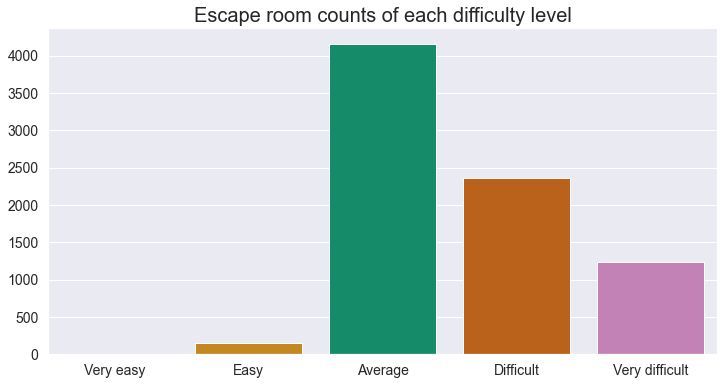

In [16]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(x = "difficulty_level", data = state_city_room_data, order = ["Very easy", "Easy", "Average", "Difficult", "Very difficult"])

# titles
plt.title("Escape room counts of each difficulty level", fontsize = 20)
plt.xlabel(None)
plt.xticks(fontsize = 14)
plt.ylabel(None)
plt.yticks(fontsize = 14)

## Success rate

/Users/nicholasmichalak/opt/anaconda3/envs/escape_room_reviews/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


(array([  0., 100., 200., 300., 400., 500.]),
 <a list of 6 Text major ticklabel objects>)

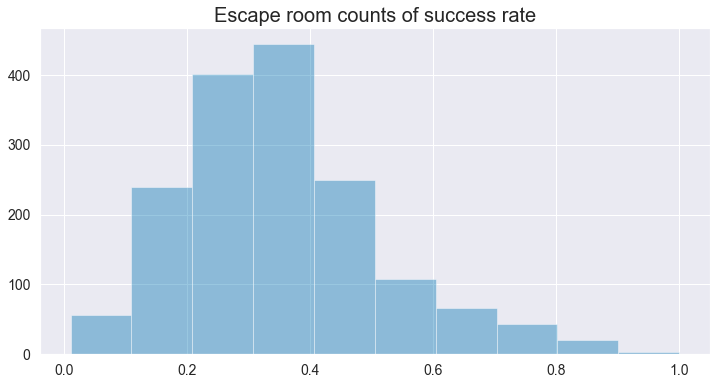

In [17]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.distplot(state_city_room_data["success_rate"].mask(state_city_room_data["success_rate"].eq("None")).dropna(), kde = False, bins = 10)

# titles
plt.title("Escape room counts of success rate", fontsize = 20)
plt.xlabel(None)
plt.xticks(fontsize = 14)
plt.ylabel(None)
plt.yticks(fontsize = 14)

## Fear level

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 <a list of 8 Text major ticklabel objects>)

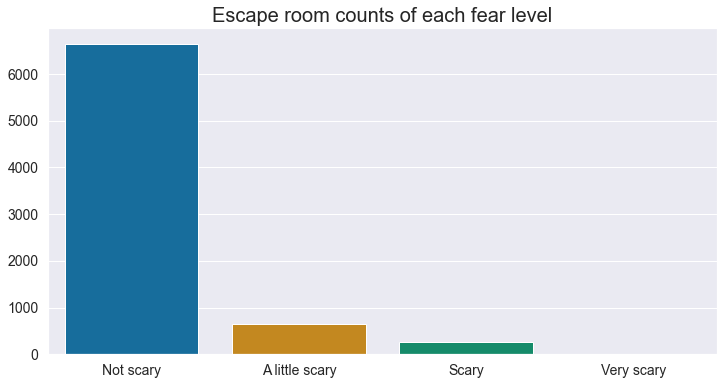

In [18]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(x = "fear_level", data = state_city_room_data, order = ["Not scary", "A little scary", "Scary", "Very scary"])

# titles
plt.title("Escape room counts of each fear level", fontsize = 20)
plt.xlabel(None)
plt.xticks(fontsize = 14)
plt.ylabel(None)
plt.yticks(fontsize = 14)

## Age requirement

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 <a list of 18 Text major ticklabel objects>)

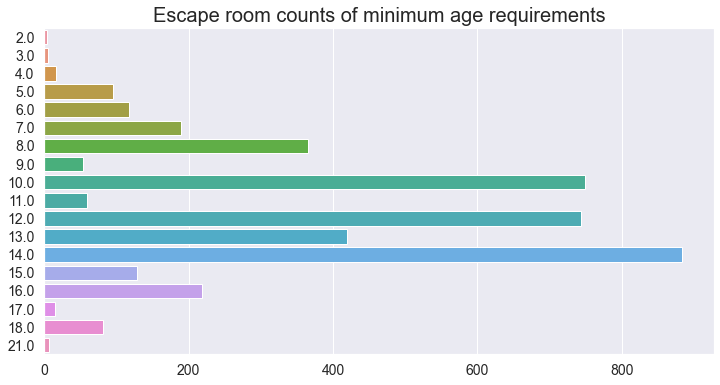

In [19]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(y = "minimum_age", data = state_city_room_data)

# titles
plt.title("Escape room counts of minimum age requirements", fontsize = 20)
plt.xlabel(None)
plt.xticks(fontsize = 14)
plt.ylabel(None)
plt.yticks(fontsize = 14)

## Time limit

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.]),
 <a list of 9 Text major ticklabel objects>)

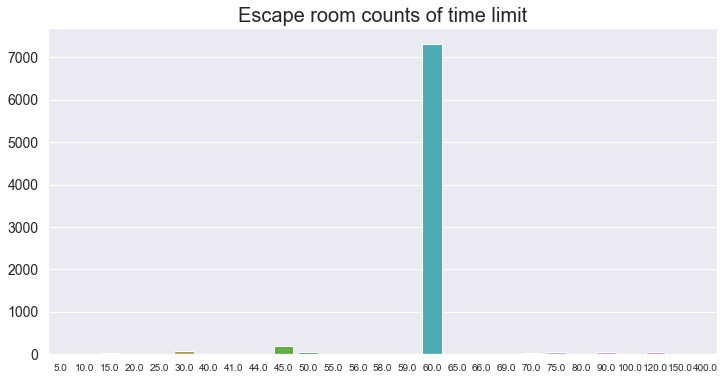

In [20]:
# figure size
plt.figure(figsize = (12, 6))

# histogram
sns.countplot(x = "time_limit", data = state_city_room_data)

# titles
plt.title("Escape room counts of time limit", fontsize = 20)
plt.xlabel(None)
plt.xticks(fontsize = 10)
plt.ylabel(None)
plt.yticks(fontsize = 14)

## Minimum number of players

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 <a list of 8 Text major ticklabel objects>)

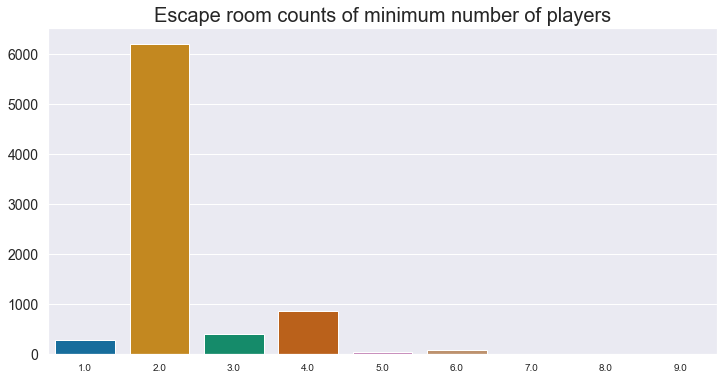

In [21]:
# conversion
state_city_room_data["min_players"] = state_city_room_data["min_players"].astype(float)

# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(x = "min_players", data = state_city_room_data)

# titles
plt.title("Escape room counts of minimum number of players", fontsize = 20)
plt.xlabel(None)
plt.xticks(fontsize = 10)
plt.ylabel(None)
plt.yticks(fontsize = 14)

## Maximum number of players

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 <a list of 37 Text major ticklabel objects>)

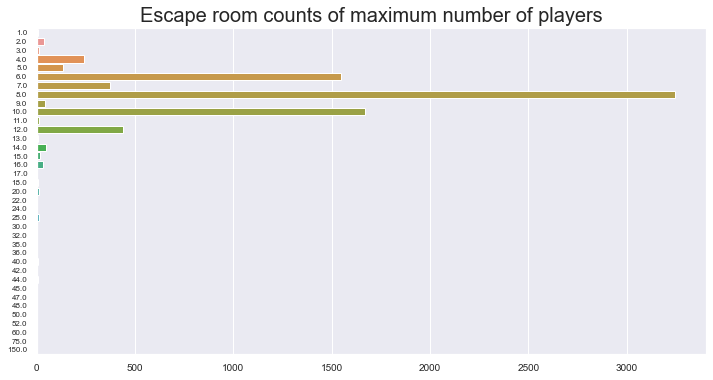

In [22]:
# conversion
state_city_room_data["max_players"] = state_city_room_data["max_players"].astype(float)

# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(y = "max_players", data = state_city_room_data)

# titles
plt.title("Escape room counts of maximum number of players", fontsize = 20)
plt.xlabel(None)
plt.xticks(fontsize = 10)
plt.ylabel(None)
plt.yticks(fontsize = 8)

## Tags

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 <a list of 38 Text major ticklabel objects>)

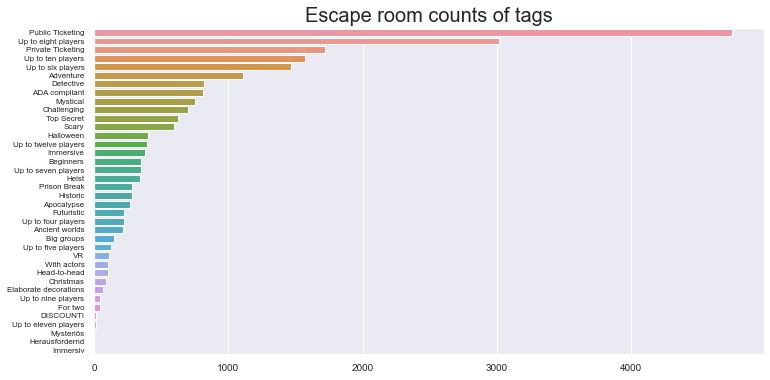

In [23]:
# figure size
plt.figure(figsize = (12, 6))

# count plot
sns.countplot(y = "tag", data = tag_data, order = tag_data["tag"].value_counts().index)

# titles
plt.title("Escape room counts of tags", fontsize = 20)
plt.xlabel(None)
plt.xticks(fontsize = 10)
plt.ylabel(None)
plt.yticks(fontsize = 8)

In [24]:
tag_data["tag"].unique()

array(['Public Ticketing', 'Up to eight players', 'Up to ten players',
       'Beginners', 'Futuristic', 'Immersive', 'Scary', 'Challenging',
       'Top Secret', 'Adventure', 'ADA compliant', 'Private Ticketing',
       'Big groups', 'VR', 'Up to four players', 'For two', 'Detective',
       'Historic', 'Mystical', 'Up to six players', 'Head-to-head',
       'Up to five players', 'Up to eleven players', 'Ancient worlds',
       'Apocalypse', 'Halloween', 'Heist', 'Christmas',
       'Up to twelve players', nan, 'Up to nine players', 'Prison Break',
       'Elaborate decorations', 'Up to seven players', 'With actors',
       'DISCOUNT!', 'Immersiv', 'Herausfordernd', 'Mysteriös'],
      dtype=object)

# Room similarity

## Features

In [25]:
# features
features = ["min_players", "max_players", "time_limit", "minimum_age", "fear_int", "difficulty_int", "success_rate"]

# See them
state_city_room_data.loc[:, features]

,min_players,max_players,time_limit,minimum_age,fear_int,difficulty_int,success_rate
0,2.0,8.0,60.0,10.0,0.0,3,0.54
1,2.0,8.0,60.0,10.0,0.0,2,0.62
2,4.0,8.0,60.0,10.0,0.0,2,NaN
3,2.0,10.0,60.0,10.0,0.0,3,0.55
4,2.0,8.0,60.0,10.0,0.0,2,0.53
...,...,...,...,...,...,...,...
7927,2.0,7.0,60.0,NaN,0.0,2,NaN
7928,2.0,4.0,60.0,NaN,0.0,2,NaN
7929,2.0,5.0,60.0,NaN,0.0,2,NaN
7930,3.0,5.0,60.0,NaN,0.0,2,NaN


### Missing data (at least one feature missing)

In [26]:
state_city_room_data.loc[:, features].isnull().any(axis = 1).sum() / len(state_city_room_data)

0.8874180534543621

### Number of features missing

In [27]:
state_city_room_data.loc[:, features].isnull().sum(axis = 1).describe()

count    7932.000000
mean        1.323248
std         0.748823
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
dtype: float64

### Remove rows with all missing features

In [28]:
# find indexes
features_all_null = state_city_room_data.loc[:, features].isnull().sum(axis = 1) == 7

# subset
escape_rooms = state_city_room_data[features_all_null == False]

# see it
escape_rooms

,index,state,city,company_and_room,woe_room_url,room_title,room_address,room_description,player_range,time_limit,...,min_players,max_players,time_limit_str,minimum_age,difficulty_int,fear_int,query_address,room_latitude,room_longitude,city_state_company_room
0,0,Alabama,Auburn,Auburn Escape Zones: The Cabin,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""The Cabin"" by Auburn Escape Zones...","1234 Commerce Dr Auburn, AL 36830",You were returning from a trip to your uncle's...,2-8,60.0,...,2.0,8.0,60 minutes,10.0,3,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338,"Auburn, Alabama - Auburn Escape Zones: The Cabin"
1,1,Alabama,Auburn,Auburn Escape Zones: Imprisoned,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Imprisoned"" by Auburn Escape Zone...","1234 Commerce Dr Auburn, AL 36830",Your friend is being framed for a crime he did...,2-8,60.0,...,2.0,8.0,60 minutes,10.0,2,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338,"Auburn, Alabama - Auburn Escape Zones: Imprisoned"
2,2,Alabama,Auburn,Auburn Escape Zones: Vault,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Vault"" by Auburn Escape Zones in ...","1234 Commerce Dr Auburn, AL 36830",It’s Grand Opening day at the new branch and p...,4-8,60.0,...,4.0,8.0,60 minutes,10.0,2,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338,"Auburn, Alabama - Auburn Escape Zones: Vault"
3,3,Alabama,Auburn,Auburn Escape Zones: The Puzzler vs Superheroes,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""The Puzzler vs Superheroes"" by Au...","1234 Commerce Dr Auburn, AL 36830",The Puzzler is up to his old tricks again! He ...,2-10,60.0,...,2.0,10.0,60 minutes,10.0,3,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338,"Auburn, Alabama - Auburn Escape Zones: The Puz..."
4,4,Alabama,Auburn,Auburn Escape Zones: Black Beard's Brig,https://worldofescapes.com/auburn/quests/aubur...,"Escape room ""Black Beard's Brig"" by Auburn Esc...","1234 Commerce Dr Auburn, AL 36830",Ahoy Matey! Your crew has been captured by Bla...,2-8,60.0,...,2.0,8.0,60 minutes,10.0,2,0.0,"1234 Commerce Dr, Auburn, AL 36830, USA",32.630708,-85.440338,"Auburn, Alabama - Auburn Escape Zones: Black B..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7927,7851,Wyoming,Gillette,307 Mysteries: Wacked Science,https://worldofescapes.com/gillette/quests/307...,"Escape room ""Wacked Science"" by 307 Mysteries ...","2800 N US Hwy 14-16, Gillette, WY 82716",A mad scientist has kidnapped you and your fri...,2-7,60.0,...,2.0,7.0,60 minutes,NaN,2,0.0,"2800 N US Hwy 14-16, Gillette, WY 82716, USA",44.322399,-105.528686,"Gillette, Wyoming - 307 Mysteries: Wacked Science"
7928,7852,Wyoming,Gillette,307 Mysteries: Lifting The Jewels,https://worldofescapes.com/gillette/quests/307...,"Escape room ""Lifting The Jewels"" by 307 Myster...","2800 N US Hwy 14-16, Gillette, WY 82716",The local Museum’s rare jewel collection was s...,2-4,60.0,...,2.0,4.0,60 minutes,NaN,2,0.0,"2800 N US Hwy 14-16, Gillette, WY 82716, USA",44.322399,-105.528686,"Gillette, Wyoming - 307 Mysteries: Lifting The..."
7929,7853,Wyoming,Gillette,307 Mysteries: Miss Molly's Zombie Reboot,https://worldofescapes.com/gillette/quests/307...,"Escape room ""Miss Molly's Zombie Reboot"" by 30...","2800 N US Hwy 14-16, Gillette, WY 82716",Zombies have escaped from containment faciliti...,2-5,60.0,...,2.0,5.0,60 minutes,NaN,2,0.0,"2800 N US Hwy 14-16, Gillette, WY 82716, USA",44.322399,-105.528686,"Gillette, Wyoming - 307 Mysteries: Miss Molly'..."
7930,7854,Wyoming,Sheridan,Escapade: Mystic Mistake,https://worldofescapes.com/sheridan/quests/esc...,"Escape room ""Mystic Mistake"" by Escapade in Sh...","237 N. Main St., Suite 50, Sheridan, WY 82801",Madam Zara has made a grave error in her quest...,3-5,60.0,...,3.0,5.0,60 minutes,NaN,2,0.0,"237 N Main St #50, Sheridan, WY 82801, USA",44.800304,-106.955458,"Sheridan, Wyomin

### Feature correlations

In [29]:
escape_rooms.loc[:, features].apply(pd.to_numeric).corr().round(2).style.background_gradient(cmap = "Reds")

,min_players,max_players,time_limit,minimum_age,fear_int,difficulty_int,success_rate
min_players,1.000000,0.120000,0.060000,0.010000,0.040000,0.070000,-0.080000
max_players,0.120000,1.000000,0.070000,-0.010000,0.000000,-0.010000,0.000000
time_limit,0.060000,0.070000,1.000000,0.040000,-0.030000,0.050000,-0.000000
minimum_age,0.010000,-0.010000,0.040000,1.000000,0.120000,0.040000,-0.070000
fear_int,0.040000,0.000000,-0.030000,0.120000,1.000000,0.070000,-0.100000
difficulty_int,0.070000,-0.010000,0.050000,0.040000,0.070000,1.000000,-0.750000
success_rate,-0.080000,0.000000,-0.000000,-0.070000,-0.100000,-0.750000,1.000000


### Export data

In [30]:
escape_rooms.to_csv("next_escape/data/escape_rooms.csv")

## Test simple imputer from sklearn

In [31]:
# dataset of weakly correlated features
X_subset = escape_rooms.loc[:, ["time_limit", "fear_int"]]

# imputer parameters (impute most frabsequent value)
imputer = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")

# fit imputation model
imputer_fit = imputer.fit(X_subset)

# predict missing values
X_subset_predict = imputer_fit.transform(X_subset)

# see results
pd.DataFrame(X_subset_predict).merge(escape_rooms["company_and_room"].to_frame(), left_index = True, right_index = True)

,0,1,company_and_room
0,60.0,0.0,Auburn Escape Zones: The Cabin
1,60.0,0.0,Auburn Escape Zones: Imprisoned
2,60.0,0.0,Auburn Escape Zones: Vault
3,60.0,0.0,Auburn Escape Zones: The Puzzler vs Superheroes
4,60.0,0.0,Auburn Escape Zones: Black Beard's Brig
...,...,...,...
7912,60.0,0.0,D.O.A. Room Escape: The Fire
7913,60.0,0.0,Great Room Escape: Houdini
7914,60.0,0.0,Great Room Escape: Zombie Room
7915,60.0,0.0,Escape Room Enigma: Secret Room of Leonardo da...


## Test iterative imputer

## Can use difficulty to impute success rate and vice versa

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 <a list of 10 Text major ticklabel objects>)

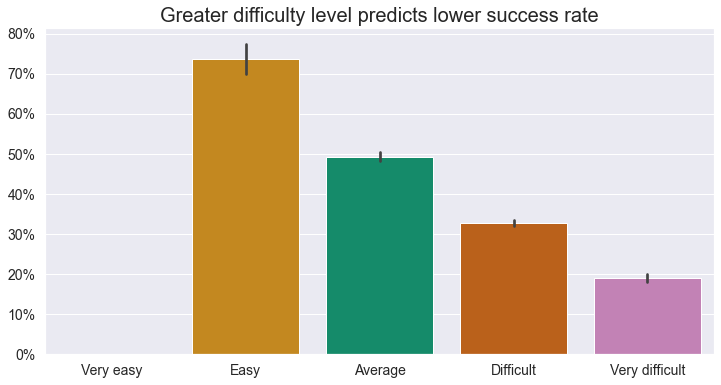

In [32]:
# figure size
plt.figure(figsize = (12, 6))

sns.barplot(x = "difficulty_level", y = "success_rate", data = state_city_room_data, order = ["Very easy", "Easy", "Average", "Difficult", "Very difficult"])

# titles
plt.title("Greater difficulty level predicts lower success rate", fontsize = 20)
plt.xlabel(None)
plt.xticks(fontsize = 14)
plt.ylabel(None)
plt.gca().set_yticklabels(["{:,.0%}".format(x) for x in plt.gca().get_yticks()])
plt.yticks(fontsize = 14)

In [33]:
# dataset of correlated features
X_correlated = escape_rooms.loc[:, ["success_rate", "difficulty_int"]]

# imputer parameters (impute predicted value)
imputer = IterativeImputer(max_iter = 10, random_state = 46914)

# fit imputation model
imputer_fit = imputer.fit(X_correlated)

# predict missing values
X_corr_predict = imputer_fit.transform(X_correlated)

# see results
pd.DataFrame(X_corr_predict).merge(escape_rooms["company_and_room"].to_frame(), left_index = True, right_index = True)

,0,1,company_and_room
0,0.540000,3.0,Auburn Escape Zones: The Cabin
1,0.620000,2.0,Auburn Escape Zones: Imprisoned
2,0.496669,2.0,Auburn Escape Zones: Vault
3,0.550000,3.0,Auburn Escape Zones: The Puzzler vs Superheroes
4,0.530000,2.0,Auburn Escape Zones: Black Beard's Brig
...,...,...,...
7912,0.496669,2.0,D.O.A. Room Escape: The Fire
7913,0.496669,2.0,Great Room Escape: Houdini
7914,0.496669,2.0,Great Room Escape: Zombie Room
7915,0.496669,2.0,Escape Room Enigma: Secret Room of Leonardo da...


## Euclidian distance matrix

In [34]:
# imputer parameters (impute most frabsequent value)
imputer_frequent = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")

# impute values for player range, time limit, and fear level
X_1_fit = imputer_frequent.fit(escape_rooms.loc[:, ["time_limit", "fear_int"]])

# predict missing values for difficulty level and success rate (bayesian ridge)
imputer_regression = IterativeImputer(max_iter = 10, random_state = 259514)

# predict missing values for player range, time limit, and fear level
X_2_fit = imputer_regression.fit(escape_rooms.loc[:, ["success_rate", "difficulty_int"]])

# impute
X_features = np.c_[X_1_fit.fit_transform(escape_rooms.loc[:, ["time_limit", "fear_int"]]), 
                   X_2_fit.fit_transform(escape_rooms.loc[:, ["success_rate", "difficulty_int"]])]

# compute euclidean distance matrix
pd.DataFrame(
    sklearn.metrics.euclidean_distances(
        sklearn.preprocessing.StandardScaler().fit_transform(X_features)
    ), index = escape_rooms["city_state_company_room"], columns = escape_rooms["city_state_company_room"])

city_state_company_room,"Auburn, Alabama - Auburn Escape Zones: The Cabin","Auburn, Alabama - Auburn Escape Zones: Imprisoned","Auburn, Alabama - Auburn Escape Zones: Vault","Auburn, Alabama - Auburn Escape Zones: The Puzzler vs Superheroes","Auburn, Alabama - Auburn Escape Zones: Black Beard's Brig","Birmingham, Alabama - Breakout Games: The Kidnapping","Birmingham, Alabama - Breakout Games: Runaway Train","Birmingham, Alabama - Breakout Games: Museum Heist","Birmingham, Alabama - Breakout Games: Do Not Disturb","Birmingham, Alabama - Breakout Games: Mystery Mansion",...,"Evanston, Wyoming - Brain Drain: Jungle Mystery","Evanston, Wyoming - Brain Drain: Portal","Evanston, Wyoming - Escape Room Enigma: Tesla","Gillette, Wyoming - 307 Mysteries: Justice Is Blind","Gillette, Wyoming - 307 Mysteries: Commie Trickery","Gillette, Wyoming - 307 Mysteries: Wacked Science","Gillette, Wyoming - 307 Mysteries: Lifting The Jewels","Gillette, Wyoming - 307 Mysteries: Miss Molly's Zombie Reboot","Sheridan, Wyoming - Escapade: Mystic Mistake","Sheridan, Wyoming - Escapade: Sherlock and the Dragon’s Eye"
city_state_company_room,,,,,,,,,,,,,,,,,,,,,
"Auburn, Alabama - Auburn Escape Zones: The Cabin",0.000000,1.428897,1.336830e+00,0.075037,1.298856,1.336830e+00,1.336830e+00,1.526499,3.020363,1.526499,...,3.020363,3.020363,2.405416,1.336830e+00,1.336830e+00,1.336830e+00,1.336830e+00,1.336830e+00,1.336830e+00,1.336830e+00
"Auburn, Alabama - Auburn Escape Zones: Imprisoned",1.428897,0.000000,9.254351e-01,1.399032,0.675329,9.254351e-01,9.254351e-01,2.490911,4.219260,2.490911,...,4.219260,4.219260,1.425695,9.254351e-01,9.254351e-01,9.254351e-01,9.254351e-01,9.254351e-01,9.254351e-01,9.254351e-01
"Auburn, Alabama - Auburn Escape Zones: Vault",1.336830,0.925435,0.000000e+00,1.357033,0.250106,2.107342e-08,2.107342e-08,1.767669,3.535338,1.767669,...,3.535338,3.535338,2.351130,2.107342e-08,2.107342e-08,2.107342e-08,2.107342e-08,2.107342e-08,2.107342e-08,2.107342e-08
"Auburn, Alabama - Auburn Escape Zones: The Puzzler vs Superheroes",0.075037,1.399032,1.357033e+00,0.000000,1.305342,1.357033e+00,1.357033e+00,1.601536,3.088301,1.601536,...,3.088301,3.088301,2.342564,1.357033e+00,1.357033e+00,1.357033e+00,1.357033e+00,1.357033e+00,1.357033e+00,1.357033e+00
"Auburn, Alabama - Auburn Escape Zones: Black Beard's Brig",1.298856,0.675329,2.501057e-01,1.305342,0.000000,2.501057e-01,2.501057e-01,1.946314,3.709857,1.946314,...,3.709857,3.709857,2.101025,2.501057e-01,2.501057e-01,2.501057e-01,2.501057e-01,2.501057e-01,2.501057e-01,2.501057e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Gillette, Wyoming - 307 Mysteries: Wacked Science",1.336830,0.925435,2.107342e-08,1.357033,0.250106,2.107342e-08,2.107342e-08,1.767669,3.535338,1.767669,...,3.535338,3.535338,2.351130,2.107342e-08,2.107342e-08,0.000000e+00,2.107342e-08,2.107342e-08,2.107342e-08,2.107342e-08
"Gillette, Wyoming - 307 Mysteries: Lifting The Jewels",1.336830,0.925435,2.107342e-08,1.357033,0.250106,2.107342e-08,2.107342e-08,1.767669,3.535338,1.767669,...,3.535338,3.535338,2.351130,2.107342e-08,2.107342e-08,2.107342e-08,0.000000e+00,2.107342e-08,2.107342e-08,2.107342e-08
"Gillette, Wyoming - 307 Mysteries: Miss Molly's Zombie Reboot",1.336830,0.925435,2.107342e-08,1.357033,0.250106,2.107342e-08,2.107342e-08,1.767669,3.535338,1.767669,...,3.535338,3.535338,2.351130,2.107342e-08,2.107342e-08,2.107342e-08,2.107342e-08,0.000000e+00,2.107342e-08,2.107342e-08


### Export feature matrix to .csv

In [35]:
pd.DataFrame(X_features).to_csv("next_escape/data/X_features.csv", index = True)

# Mock-up data product

## Input 1: User location where user is looking for escape rooms

In [36]:
user_address, user_latitude, user_longitude = get_lat_long("Denver, CO, USA")

# See them
print("Address: {} (Latitude: {}, Longitude: {})".format(user_address, user_latitude, user_longitude))

Address: Denver, CO, USA (Latitude: 39.7392358, Longitude: -104.990251)


## Input 2: User's favorite game

In [37]:
favorite_game = "Denver, Colorado - The Wreck Room Escape Game: The Curse"

## Input 3: Distance in miles the user is willing to travel

In [38]:
miles_limit = 25

## Input 4: User group size

In [39]:
group_size = 5

## Input 5: Youngest person in user's group

In [40]:
youngest_person = 14

## Compute distance from user input address to all escape rooms 

In [41]:
room_distance = [distance.geodesic((user_latitude, user_longitude), (lat, long)).miles if np.isnan(lat) == False else None for lat, long in zip(escape_rooms["room_latitude"], escape_rooms["room_longitude"])]

# see some
room_distance[0:11]

[1194.2370636729381,
 1194.2370636729381,
 1194.2370636729381,
 1194.2370636729381,
 1194.2370636729381,
 1097.3539070150891,
 1097.3539070150891,
 1097.3539070150891,
 1097.3539070150891,
 1097.3539070150891,
 1097.3539070150891]

## Rank game rooms by similarity

In [42]:
(dissimilarity_matrix
.loc[favorite_game]
.sort_values()
.to_frame()
.reset_index()
.rename(columns = {favorite_game: "distance"}))

,city_state_company_room,distance
0,"Portland, Oregon - Mindfield Escapes: The Mind...",0.000000
1,"San Diego, California - 3rd Day Escape: Takeover",0.000000
2,"San Francisco, California - Sandbox VR: UFL VR",0.000000
3,"San Diego, California - Steal and Escape: Take...",0.000000
4,"San Francisco, California - Sandbox VR: Star T...",0.000000
...,...,...
7912,"Orlando, Florida - The Escape Effect: A Knight...",10.895711
7913,"Seattle, Washington - Locurio: Hunt A Killer",11.052770
7914,"Seattle, Washington - Escape Scene: Hunt A Killer",11.052770
7915,"Missoula, Montana - Big Sky Breakout: Operatio...",13.741610


## Return 3 similar

In [43]:
user_recommendations, user_distances = dissimilarity_matrix.loc[favorite_game].sort_values().index[:4].tolist(), dissimilarity_matrix.loc[favorite_game].sort_values().values[:4].tolist()

# see them
for recommendation, miles in zip(user_recommendations, user_distances):
    print("Recommendation {} (Dissimilarity: {})".format(recommendation, miles))

Recommendation Portland, Oregon - Mindfield Escapes: The Mind Field (Dissimilarity: 0.0)
Recommendation San Diego, California - 3rd Day Escape: Takeover (Dissimilarity: 0.0)
Recommendation San Francisco, California - Sandbox VR: UFL VR (Dissimilarity: 0.0)
Recommendation San Diego, California - Steal and Escape: Takeover (Dissimilarity: 0.0)


## Face validity (check (dis)similarity next to actual features)

In [44]:
escape_rooms.loc[escape_rooms["city_state_company_room"].isin(user_recommendations), ["company_and_room", "query_address", "woe_room_url", "player_range", "time_limit", "difficulty_level", "success_rate", "fear_level", "minimum_age"]]

,company_and_room,query_address,woe_room_url,player_range,time_limit,difficulty_level,success_rate,fear_level,minimum_age
895,Steal and Escape: Takeover,"2602 Transportation Ave Suite B, National City...",https://worldofescapes.com/san-diego/quests/st...,3-8,30.0,Average,NaN,Not scary,16.0
896,3rd Day Escape: Takeover,"2602 Transportation Ave Suite B, National City...",https://worldofescapes.com/san-diego/quests/st...,3-8,30.0,Average,NaN,Not scary,16.0
998,Sandbox VR: UFL VR,"Hillsdale Shopping Center Zone H (Upper Level,...",https://worldofescapes.com/sfbay/quests/sandbo...,4-6,30.0,Average,NaN,Not scary,18.0
5801,Mindfield Escapes: The Mind Field,"11830 Kerr Pkwy #330, Lake Oswego, OR 97035, USA",https://worldofescapes.com/portland/quests/min...,1-4,30.0,Average,NaN,Not scary,NaN


In [45]:
# Remember the user input game
favorite_game

'Denver, Colorado - The Wreck Room Escape Game: The Curse'

## Combine steps in one function

In [46]:
def favorite_room(user_location, miles_limit, group_size, youngest_person, favorite_room):
    # user location data
    user_address_query, user_latitude, user_longitude = get_lat_long(user_location)
    
    # compute miles away from each room in database
    miles2room = [distance.geodesic((user_latitude, user_longitude), (lat, long)).miles if np.isnan(lat) == False else None for lat, long in zip(escape_rooms["room_latitude"], escape_rooms["room_longitude"])]
    
    # add to data frame
    escape_rooms["miles2room"] = miles2room
    
    # rank rooms based on similarity to room user input
    rooms_ranked = (dissimilarity_matrix
                    .loc[favorite_room]
                    .sort_values()
                    .to_frame()
                    .reset_index()
                    .rename(columns = {"index": "city_state_company_room", favorite_room: "dissimilarity"}))

    # left join with subset of escape rooms
    escape_rooms_subset = rooms_ranked.merge(escape_rooms, how = "left", on = "city_state_company_room")
    
    # subset escape rooms to rooms within travel limit and don't exclude group size or the youngest group member(s)
    escape_rooms_subset = escape_rooms_subset.loc[((escape_rooms_subset["miles2room"] <= miles_limit) & (escape_rooms_subset["max_players"] >= group_size) & (escape_rooms_subset["minimum_age"] <= youngest_person)) | (escape_rooms_subset["city_state_company_room"] == favorite_room), :]
 
    # 3 most similar
    recommended_rooms = escape_rooms_subset["city_state_company_room"].values[:4].tolist()
    
    # recommendation table
    recommendation_table = escape_rooms_subset.loc[escape_rooms_subset["city_state_company_room"].isin(recommended_rooms), ["company_and_room", "woe_room_url", "query_address", "miles2room", "player_range", "time_limit_str", "difficulty_level", "success_rate", "fear_level", "minimum_age", "dissimilarity"]].sort_values(by = "dissimilarity")

    return recommendation_table

### Test `favorite_room()` function

In [47]:
favorite_room(user_location = "Denver, CO", miles_limit = 25, group_size = 5, youngest_person = 14, favorite_room = "Denver, Colorado - The Wreck Room Escape Game: The Curse")

/Users/nicholasmichalak/opt/anaconda3/envs/escape_room_reviews/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,company_and_room,woe_room_url,query_address,miles2room,player_range,time_limit_str,difficulty_level,success_rate,fear_level,minimum_age,dissimilarity
35,The Wreck Room Escape Game: The Curse,https://worldofescapes.com/denver/quests/puzza...,"1 W Flatiron Crossing Dr, Broomfield, CO 80021...",15.375804,2-6,30 minutes,Average,NaN,Not scary,NaN,0.000000
240,"""Try'n Escape"": Detention",https://worldofescapes.com/denver/quests/key-q...,"8988 E Hampden Ave, Denver, CO 80231, USA",8.327587,3-6,45 minutes,Easy,NaN,Not scary,12.0,2.464782
2802,Enigma Escape Rooms: The Missing Scientist: Pa...,https://worldofescapes.com/longmont/quests/Eni...,"1426 Pearl St #020, Boulder, CO 80302, USA",24.542055,2-8,60 minutes,Average,NaN,Not scary,12.0,3.435402
2805,Enigma Escape Rooms: The Missing Scientist: Pa...,https://worldofescapes.com/longmont/quests/eni...,"1426 Pearl St #020, Boulder, CO 80302, USA",24.542055,2-8,60 minutes,Average,NaN,Not scary,12.0,3.435402


## Define ideal room function

In [48]:
def ideal_room(user_location, miles_limit, group_size, youngest_person, time_limit_str, fear_level, difficulty_level):
    # user location data
    user_address_query, user_latitude, user_longitude = get_lat_long(user_location)
    
    # compute miles away from each room in database
    miles2room = [distance.geodesic((user_latitude, user_longitude), (lat, long)).miles if np.isnan(lat) == False else None for lat, long in zip(escape_rooms["room_latitude"], escape_rooms["room_longitude"])]

    # add to data frame
    escape_rooms["miles2room"] = miles2room
    
    # new row
    ideal_features = pd.DataFrame({"company_and_room": "Your Ideal Escape Room", "woe_room_url": np.nan, "query_address": user_address_query, "miles2room": 0, "player_range": str(group_size) + " or more", "time_limit_str": time_limit_str, "difficulty_level": difficulty_level, "success_rate": np.nan, "fear_level": fear_level, "minimum_age": "Younger than " + str(youngest_person)}, index = [0])
    
    # predict success rate
    predict_succes_rate = sklearn.linear_model.LinearRegression().fit(escape_rooms[["success_rate", "difficulty_int"]].dropna().to_numpy()[:, 1].reshape(-1, 1), 
                                                                      escape_rooms[["success_rate", "difficulty_int"]].dropna().to_numpy()[:, 0].reshape(-1, 1))
    
    # modify variables
    ideal_features = ideal_features.assign(time_limit = time_limit_str.split(" minutes")[0],
                                           difficulty_int = recode_difficulty(difficulty_level),
                                           success_rate = predict_succes_rate.predict([[recode_difficulty(difficulty_level)]]),
                                           fear_int = recode_fear(fear_level))
    
    # append features
    X = np.r_[X_features, ideal_features.loc[:, ["time_limit", "fear_int", "difficulty_int", "success_rate"]]]
    
    # compute euclidean distance matrix
    dissimilarity_matrix = pd.DataFrame(
    sklearn.metrics.euclidean_distances(
        sklearn.preprocessing.StandardScaler().fit_transform(X)
    ), index = escape_rooms["city_state_company_room"].append(pd.Series(["Your Ideal Escape Room"]), ignore_index = True), 
    columns = escape_rooms["city_state_company_room"].append(pd.Series(["Your Ideal Escape Room"]), ignore_index = True))
    
    # rank rooms based on similarity to room user input
    rooms_ranked = (dissimilarity_matrix
                    .loc["Your Ideal Escape Room"]
                    .sort_values()
                    .to_frame()
                    .reset_index()
                    .rename(columns = {"index": "city_state_company_room", "Your Ideal Escape Room": "dissimilarity"}))

    # left join with subset of escape rooms
    escape_rooms_subset = rooms_ranked.merge(escape_rooms, how = "left", on = "city_state_company_room")
    
    # subset escape rooms to rooms within travel limit
    escape_rooms_subset = escape_rooms_subset.loc[((escape_rooms_subset["miles2room"] <= miles_limit) & (escape_rooms_subset["max_players"] >= group_size) & (escape_rooms_subset["minimum_age"] <= youngest_person)) | (escape_rooms_subset["city_state_company_room"] == "Your Ideal Escape Room"), :]
 
    # 3 most similar
    recommended_rooms = escape_rooms_subset.loc[:, "city_state_company_room"].values[:4].tolist()
    
    # recommendation table
    recommendation_table = escape_rooms_subset.loc[escape_rooms_subset["city_state_company_room"].isin(recommended_rooms), ["company_and_room", "woe_room_url", "query_address", "miles2room", "player_range", "time_limit_str", "difficulty_level", "success_rate", "fear_level", "minimum_age", "dissimilarity"]].sort_values(by = "dissimilarity")
    
    # replace nan
    recommendation_table.loc[0, ["company_and_room", "woe_room_url", "query_address", "miles2room", "player_range", "time_limit_str", "difficulty_level", "success_rate", "fear_level", "minimum_age"]] = ideal_features.loc[0, ["company_and_room", "woe_room_url", "query_address", "miles2room", "player_range", "time_limit_str", "difficulty_level", "success_rate", "fear_level", "minimum_age"]].tolist()
    
    return recommendation_table

### Test `ideal_room()` function

In [49]:
ideal_room(user_location = "Denver, CO", miles_limit = 25, group_size = 5, youngest_person = 14, time_limit_str = "60 minutes", fear_level = "Very scary", difficulty_level = "Very difficult")

/Users/nicholasmichalak/opt/anaconda3/envs/escape_room_reviews/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,company_and_room,woe_room_url,query_address,miles2room,player_range,time_limit_str,difficulty_level,success_rate,fear_level,minimum_age,dissimilarity
0,Your Ideal Escape Room,NaN,"Denver, CO, USA",0.000000,5 or more,60 minutes,Very difficult,0.176374,Very scary,Younger than 14,0.000000
179,"""Try'n Escape"": Detention",https://worldofescapes.com/denver/quests/key-q...,"8988 E Hampden Ave, Denver, CO 80231, USA",8.327587,3-6,45 minutes,Easy,NaN,Not scary,12,24.966088
375,Bible Treks Christian Escape Room: Zombie Nursery,https://worldofescapes.com/denver/quests/light...,"1500 W Littleton Blvd Unit 110 C/D, Littleton,...",8.793067,2-6,60 minutes,Average,NaN,Scary,13,25.361935
378,Puzzah!: Escape Mars,https://worldofescapes.com/denver/quests/escap...,"3489 W 72nd Ave #203, Westminster, CO 80030, USA",6.507182,2-8,60 minutes,Average,NaN,Scary,10,25.361935


# For Insight Demo

## Heatmap of rooms across U.S.

In [50]:
# configure api
gmaps.configure(api_key = api_key)

# location tuples
locations = [(latitude, longitude) for latitude, longitude in zip(escape_rooms["room_latitude"], escape_rooms["room_longitude"]) if np.isnan(latitude) == False]

# figure
gmaps_figure = gmaps.figure()
gmaps_figure.add_layer(gmaps.heatmap_layer(locations))

# see it
gmaps_figure

Figure(layout=FigureLayout(height='420px'))

In [56]:
escape_rooms.fear_int.describe()

count    7571.000000
mean        0.160877
std         0.466309
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: fear_int, dtype: float64